# Выбор локации для скважины

Мы работаем в добывающей компании. Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищем месторождения, для каждого определяем значения признаков;
- Строим модель и оценивают объём запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [ ]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

plt.style.use('dark_background')

In [ ]:
# переменные с датасетами
try:
    geo0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo0 = pd.read_csv('geo_data_0.csv')
    geo1 = pd.read_csv('geo_data_1.csv')
    geo2 = pd.read_csv('geo_data_2.csv')

In [ ]:
#переменная для фиксирования случайности (иметь бы такую в жизни)
RANDOM_STATE = 42
state = np.random.RandomState(42)

In [ ]:
# смотрим на первый датасет
geo0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [ ]:
# второй датасет
geo1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [ ]:
# третий датасет
geo2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [ ]:
# пропуски в данных
print(f'Первый регион: \n{geo0.isna().mean()}')
print('-'*15)
print(f'Второй регион: \n{geo1.isna().mean()}')
print('-'*15)
print(f'Третий регион: \n{geo2.isna().mean()}')

Первый регион: 
id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64
---------------
Второй регион: 
id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64
---------------
Третий регион: 
id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64


In [ ]:
# дубликаты по скважинам первого региона
geo0.duplicated(subset=['id']).mean()

0.0001

In [ ]:
# дубликаты по скважинам первого региона
geo0[geo0.duplicated(subset=['id'], keep=False)].sort_values(by='product', ascending=False)

,id,f0,f1,f2,product
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
64022,74z30,0.741456,0.459229,5.153109,140.771492
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
66136,74z30,1.084962,-0.312358,6.990771,127.643327
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
16633,fiKDv,0.157341,1.028359,5.585586,95.817889


Видим, что у одной и той же скважины разные ресурсы, такого быть не может - очищаем данные, неизвестно какая из скважин актуальная

In [ ]:
# дубликаты по скважинам второго региона
geo1.duplicated(subset=['id']).mean()

4e-05

In [ ]:
# дубликаты по скважинам
geo1[geo1.duplicated(subset=['id'], keep=False)].sort_values(by='product', ascending=False)

,id,f0,f1,f2,product
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103


In [ ]:
# дубликаты по скважинам третьего региона
geo2.duplicated(subset=['id']).mean()

4e-05

In [ ]:
# дубликаты по скважинам
geo2[geo2.duplicated(subset=['id'], keep=False)].sort_values(by='product', ascending=False)

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525


Такая же ситуация и по двум другим регионам - удаляем эти дубликаты, необходимо сообщить разработчикам о найденом, чтобы они нашли причину появления дубликатов

In [ ]:
# очищаем данные от мусора
for data in [geo0, geo1, geo2]:
    data = data.drop_duplicates(subset='id', keep=False)

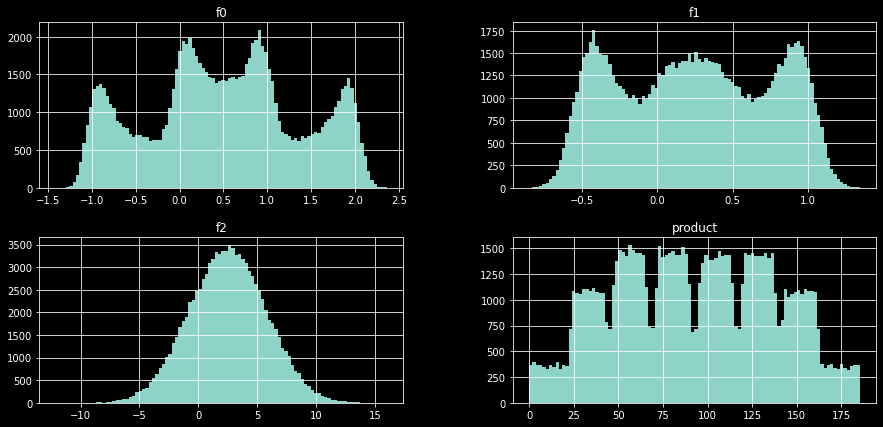

In [ ]:
# распределение признаков первого региона
geo0.hist(figsize=(15, 7), bins=100);

Похоже признакам f0 и f1 не хватает \ОоО/ глаз

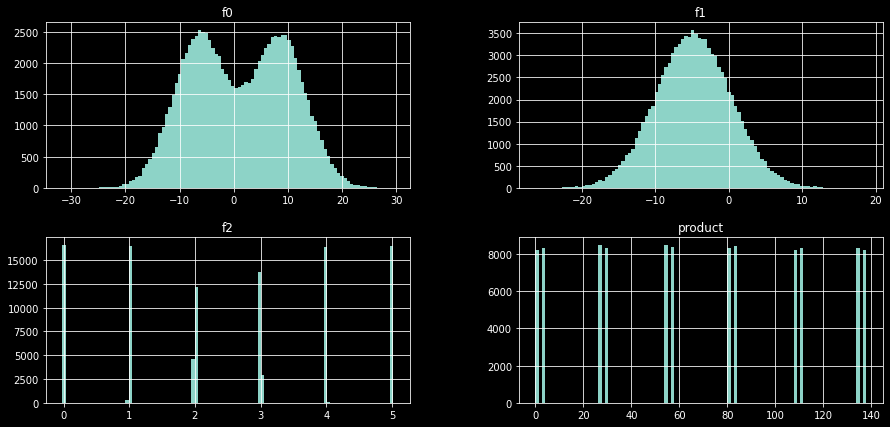

In [ ]:
# распределение признаков второго региона
geo1.hist(figsize=(15, 7), bins=100);

Похоже, что данные разрежжены

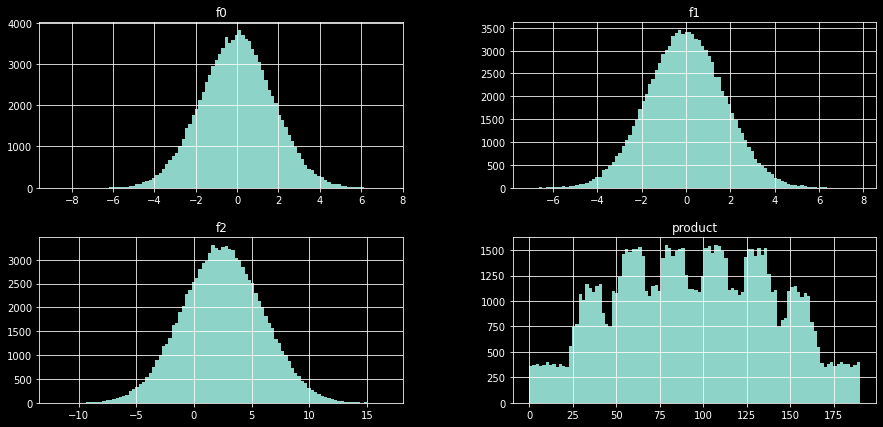

In [ ]:
# распределение признаков второго региона
geo2.hist(figsize=(15, 7), bins=100);

Теперь посмотрим мнение метода Пирсона

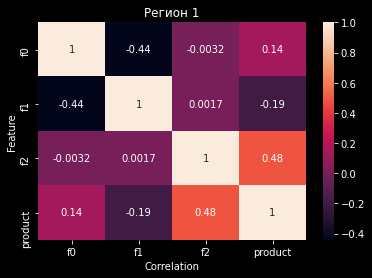

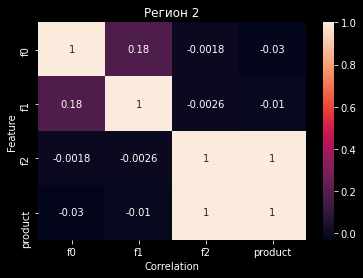

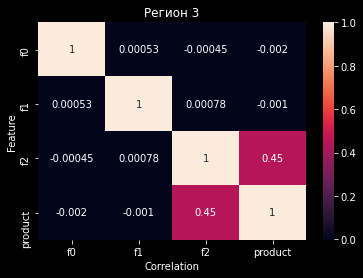

In [ ]:
count = 1
data_list = [geo0, geo1, geo2]
for correl in data_list:
    geo_corr = correl.corr()
    sns.heatmap(geo_corr, annot=True);
    plt.title('Регион ' + str(count))
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.show()
    count += 1

Видим, что присутствует отрицательная слабая зависимость в первом регионе между признаками f0 и f1, во втором регионе очень сильная зависимость между целевым признаком и признаком f2



Данные готовы к исследованию

#### Промежуточный вывод:
Мы имеем 100.000 объектов и 5 признаков по каждому из трех регионов,   
очистили данные и посмотрели распределения, теперь готовы перейти к исследованию


---

## Обучение и проверка модели

In [ ]:
# выведем для удобства
geo0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [ ]:
#фичи и таргет
X = geo0.columns.drop(['id', 'product'])
y= ['product']

# функция для обучения модели и получения метрики и датафрейма с таргетом и предскзанием
def model_predict(data: pd.DataFrame):
    ''' Получение датафрейма с таргетом и предсказанием тестовой выборки и скора(RMSE)

    :param data: данные по региону, представленные в виде pandas.DataFrame

    Переменные модели:
    - pipline: создаем конвейер с масштабированием данных и моделью линейной регрессии
    - model: обученная модель на тренировочной выборке
    - y_pred:  предсказание модели переформатированное в Series
    - score:  RMSE предсказания
    - target_pred_data: объединение таргета тестовой выборки и предсказания

    # выводим средний запас региона по тестовой выборке и метрику
    - return:  на выход получаем датафрейм с объединенными таргетом и предсказанием и скор модели
    '''

    pipeline = make_pipeline(StandardScaler(), LinearRegression())

    train, test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

    model = pipeline.fit(train[X], train[y])

    y_pred = model.predict(test[X])
    y_pred = pd.Series(y_pred.flatten())

    score = mean_squared_error(test[y], y_pred, squared=False)

    target_pred_data = pd.concat([test[y].reset_index(drop=True), y_pred], axis=1)

    target_pred_data = target_pred_data.rename(columns={"product": "target", 0: "pred"})

    print(f'Средний запас региона по предсказанному на тестовой выборке {y_pred.mean():.2f}')

    print(f'RMSE региона: {score:.2f}')

    return target_pred_data, score

In [ ]:
# получаем тестовую выборку первого региона
test0, rmse0 = model_predict(geo0)

Средний запас региона по предсказанному на тестовой выборке 92.40
RMSE региона: 37.76


In [ ]:
# смотрим все ли нормально записалось
test0.isna().mean()

target    0.0
pred      0.0
dtype: float64

In [ ]:
# получаем тестовую выборку второго региона
test1, rmse1 = model_predict(geo1)

Средний запас региона по предсказанному на тестовой выборке 68.71
RMSE региона: 0.89


In [ ]:
# смотрим все ли нормально записалось
test1.isna().mean()

target    0.0
pred      0.0
dtype: float64

Видим, что очень высокая корреляция свела ошибку к минимуму

Теперь все отлично  
  
Теперь получим данные о третьем регионе

In [ ]:
X = geo0.columns.drop(['id', 'product'])
test2, rmse2 = model_predict(geo2)

Средний запас региона по предсказанному на тестовой выборке 94.77
RMSE региона: 40.15


In [ ]:
# смотрим все ли нормально записалось
test2.isna().mean()

target    0.0
pred      0.0
dtype: float64

Теперь мы видим, что у второго региона идеальная для нас RMSE и довольно маленький запас, в отличии от остальных двух регионов, у третьего региона самые большие запасы, но ошибка выше, чем у первого

---

## Подготовка к расчёту прибыли

### Наши вводные данные:  
+ Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  

+ При разведке региона исследуем 500 точек, из которых с помощью машинного обучения выбираем 200 лучших для разработки.  
+ Бюджет на разработку скважин в регионе — 10 млрд рублей.  
+ При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
+ После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбираем регион с наибольшей средней прибылью.  
  

---

  
Занесем эти данные в переменные:

In [ ]:
# исследование 500 точек
EXPLORE_POINTS = 500

# финальная выборка лучшие 200 точек
TOP_POINTS = 200

# бюджет на разработку скважин
BUDGET = 1e10

# 1 баррель 450 рублей, единица продукта - 450 тысяч рублей, объем указан в тысячах баррелей
PROD_UNIT = 450 * 10**3

# безубыточный объем сырья
LOSS_FREE = BUDGET / PROD_UNIT

# средний объем региона для безубыточной разработки
MEAN_LOSS_FREE = LOSS_FREE / TOP_POINTS

In [ ]:
# посмотрим на всю информацию по средним запасам регионов
#для сравнения с безубыточной границей объема

print(f'Достаточный объём сырья в регионе для безубыточной разработки новых скважин: {LOSS_FREE:.2f}')
print(f'Средний объем, который необходим для прохождения точки безубыточности: {MEAN_LOSS_FREE:.2f}')
print('-' * 75)
print(f'Средний объем сырья в первом регионе тестовой выборки: {test0["pred"].mean():.2f}\n')
print(f'Средний объем сырья вo втором регионе тестовой выборки: {test1["pred"].mean():.2f}\n')
print(f'Средний объем сырья в третьем регионе тестовой выборки: {test2["pred"].mean():.2f}\n')


Достаточный объём сырья в регионе для безубыточной разработки новых скважин: 22222.22
Средний объем, который необходим для прохождения точки безубыточности: 111.11
---------------------------------------------------------------------------
Средний объем сырья в первом регионе тестовой выборки: 92.40

Средний объем сырья вo втором регионе тестовой выборки: 68.71

Средний объем сырья в третьем регионе тестовой выборки: 94.77



In [ ]:
# средние запасы генеральных совокупностей по регионам
print(f'Среднее всей совокупности первого региона: {geo0.describe().iloc[1, 3]:.2f}\n')
print(f'Среднее всей совокупности второго региона: {geo1.describe().iloc[1, 3]:.2f}\n')
print(f'Среднее всей совокупности третьего региона: {geo2.describe().iloc[1, 3]:.2f}\n')

Среднее всей совокупности первого региона: 92.50

Среднее всей совокупности второго региона: 68.83

Среднее всей совокупности третьего региона: 95.00



Видим, что ни один регион пока не может дать нам необходимый объем для безубыточной разработки

Но все же первый и третий регион лидируют по среднему количеству объема сырья

## Расчёт прибыли и рисков

In [ ]:
# функция для подсчета прибыли
def calculate_profit(data: pd.DataFrame):
    """Рассчитывает прибыль по выбранным на предсказании скважинам и целевому признаку
    """
    selected = data.sort_values(by='pred', ascending=False)[:TOP_POINTS]
    return (selected['target'] * PROD_UNIT).sum() - BUDGET

In [ ]:
# функция для иследования методом бутстреп по датасету региона
def bootstrap_calc(data: pd.DataFrame):
    ''' С помощью метода бутстреп получаем статистики по региону

    :param data: тестовая выборка полученная с помощью функции model_pred

    - values: -> list, в который сохраняются значения прибыли семпла
    - prob_loss: -> int, счетчик для расчета процента риска

    - target_sample: сэмпл взятый по датафрейму полученному на входе функции
    - profit: расчет прибыли функцией calculate_profit
    - mean_profit: среднее значение прибыли
    - loss: расчет процента риска
    - lower: нижняя граница доверительного 95% интервала
    - upper: верхняя граница доверительного 95% интервала

    '''

    values=[]
    prob_loss = 0
    for i in range(1000):
        target_sample = data.sample(replace=True, random_state=state, n=EXPLORE_POINTS)
        profit = calculate_profit(target_sample)
        if profit < 0:
            prob_loss +=1
        values.append(profit)

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean_profit = values.mean()
    loss = prob_loss / 1000


    print(f'Средняя прибыль региона:  {mean_profit:.2f}')
    print(f'95% доверительный интервал в промежутке между: {(lower, upper)}')
    print(f'Процент риска потерь: {loss:.2%}')

    return mean_profit, (lower, upper), loss

In [ ]:
print('Статистика по первому региону')
mean_profit0, interval0, loss0 = bootstrap_calc(test0)

Статистика по первому региону
Средняя прибыль региона:  399575478.05
95% доверительный интервал в промежутке между: (-110467895.33197045, 897460327.7178774)
Процент риска потерь: 6.00%


In [ ]:
print('Статистика по второму региону')
mean_profit1, interval1, loss1 = bootstrap_calc(test1)

Статистика по второму региону
Средняя прибыль региона:  452576594.29
95% доверительный интервал в промежутке между: (52309409.80273653, 830146313.2647407)
Процент риска потерь: 0.90%


In [ ]:
print('Статистика по третьему региону')
mean_profit2, interval2, loss2 = bootstrap_calc(test2)

Статистика по третьему региону
Средняя прибыль региона:  378705903.66
95% доверительный интервал в промежутке между: (-127779434.98830605, 907923483.221061)
Процент риска потерь: 7.50%


Как мы видим, только один регион смог преодолеть порог в 2.5%, с достаточно хорошей прибылью

---

## Вывод:
  

Мы провели небольшое, но интересное исследование:
  
- нашли ошибку перезаписи данных с дубликатами одних и тех же скважин с разными объемами сырья,  
- посмотри на интересные распределения синтетических данных,  
- нашли очень большую корреляцию признака и целевого признака во втором регионе,   
- предсказали моделью линейной регрессии запасы в регионах,   
- рассчитали минимальный средний объем сырья на регион, для прохождения точки безубыточности - 111.11, ни в одном регионе не оказалось средних запасов достаточно
- рассчитали статистики для каждого региона методом нескольких случайных выборок и выяснили, второй регион нам полностью подходит так как риск потерь не превышает наш порог в 2.5% и с ним мы получаем прибыль выше, чем у остальных двух   
- Наш выбор Регион номер два!